#### This one has batch normalization

In [1]:
import gzip
import pickle
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from getConfig import getConfig
from getData import getData
from getSet import getSet
from normalizeData import normalize
import prepData

In [2]:
def createVal(d):
    # Split Training into Train and Val. They are already shuffled so just take bottom 20% for Val
    valSize = int(d["trainX"].shape[0]*.2)
    trainSize = d["trainX"].shape[0] - valSize
    d["trainX"] = d["trainX"].head(trainSize)
    d["trainY"] = d["trainY"].head(trainSize)
    d["valX"] = d["trainX"].tail(valSize)
    d["valY"] = d["trainY"].tail(valSize)
    
    del d['testX']["unit"]
    return d

In [3]:
def createDataDict(config, Set=1):
    train, test = getData(config)    # ignore Test to setup the auto-encoder
    train = getSet(train, Set)
    
    d = prepData.process(train, test, config)
    d = normalize(d, "Std")
    d = createVal(d)
    return d

In [4]:
config = getConfig()
dataDict = createDataDict(config)

/home/tbrownex/tensorflow/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tbrownex/tensorflow/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/tbrownex/tensorflow/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tbrownex/tensorflow/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [5]:
# No need for labels in an auto-encoder
del dataDict["trainY"]
del dataDict["valY"]
del dataDict["testY"]

In [6]:
feature_count = dataDict["trainX"].shape[1]

In [113]:
# NN hyper-parameters
l1_size       = 20          # Count of nodes in layer 1
l2_size       = 6           # Count of nodes in layer 2
l3_size       = l1_size
output_size   = feature_count
lr            = .0001
LAMBDA        = 0.0          # Regularization parameter
batch_size    = 32
epochs        = 80
activation    = ['ReLU']           # 'tanh' 'leakyReLU' 'ReLU' 'relu6' 'elu' 'crelu'
STD           = [0.2]

actf = tf.nn.relu

# Small epsilon value for the BN transform
epsilon = 1e-3

In [114]:
def batch_norm_wrapper(inputs, training, decay = 0.999):

    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if training:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                                             batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
                                         pop_mean, pop_var, beta, scale, epsilon)

In [115]:
# Set up the network
tf.reset_default_graph()

training = True

X  = tf.placeholder("float", shape=[None, feature_count], name="input")

l1w = tf.Variable(tf.truncated_normal([feature_count, l1_size], stddev=STD, dtype=tf.float32))
l2w = tf.Variable(tf.truncated_normal([l1_size, l2_size], stddev=STD, dtype=tf.float32))
l3w = tf.Variable(tf.truncated_normal([l2_size, l3_size], stddev=STD, dtype=tf.float32))
l4w = tf.Variable(tf.truncated_normal([l3_size, feature_count], stddev=STD, dtype=tf.float32))

l1b = tf.Variable(tf.zeros(l1_size))
l2b = tf.Variable(tf.zeros(l2_size))
l3b = tf.Variable(tf.zeros(l3_size))
l4b = tf.Variable(tf.zeros(feature_count))

# Layer 1
l1 = tf.matmul(X,l1w)
bn1 = batch_norm_wrapper(l1, training)
l1_out = actf(bn1)

l2_out = actf(tf.matmul(l1_out,l2w)+l2b)
l3_out = actf(tf.matmul(l2_out,l3w)+l3b)
output = actf(tf.matmul(l3_out,l4w)+l4b)

In [116]:
rmse      = tf.sqrt(tf.reduce_mean(tf.square(output - X)))
L1_layer1 = LAMBDA**tf.reduce_sum(tf.abs(l1w))
L2_layer1 = LAMBDA*tf.nn.l2_loss(l1w)
L1_layer3 = LAMBDA**tf.reduce_sum(tf.abs(l3w))
L2_layer3 = LAMBDA*tf.nn.l2_loss(l3w)
    
cost = tf.reduce_mean(rmse + L1_layer1 + L2_layer1 + L2_layer3 + L2_layer3)

optimizer = tf.train.AdamOptimizer(lr)
train     = optimizer.minimize(cost)

In [117]:
init=tf.global_variables_initializer()

In [118]:
num_training_batches = int(dataDict["trainX"].shape[0] / batch_size)
print("{} training batches of size {}".format(num_training_batches, batch_size))

515 training batches of size 32


In [121]:
with tf.Session() as sess:
    print("Epoch   Validation Loss")
    sess.run(init)
    
    for i in range(epochs):
        data = shuffle(dataDict["trainX"])
        for j in range(num_training_batches):
            x_mini = data[j*batch_size:j*batch_size+batch_size]
            _ = sess.run(train, feed_dict = {X: x_mini})
        if i % 5 == 0:
            valLoss = sess.run(rmse, feed_dict={X:dataDict["valX"]})
            print("{:<8}{:.3f}".format(i, valLoss))
    print("\n")
    training = False
    final, recreated = sess.run([rmse, output], feed_dict = {X: dataDict["trainX"]})
    print("{:<8}{:.3f}".format("Training", final))

Epoch   Validation Loss
0       0.847
5       0.758
10      0.752
15      0.748
20      0.746
25      0.744
30      0.743
35      0.742
40      0.741
45      0.741
50      0.740
55      0.740
60      0.740
65      0.740
70      0.739
75      0.739


Training0.745


In [131]:
diff = recreated - np.array(dataDict["trainX"])

In [135]:
count = 0
for x in range(diff.shape[0]):
    if sum(diff[x]>3.0) > 1:
        print(x, diff[x])
        break

518 [-0.39477942  1.00176907  1.71418605  0.          0.         -0.12084343
 -1.82137982 -2.3761444   1.         -0.0571694   2.53958349  0.08955512
  1.36819444  0.         -0.26638141  3.35369615 -2.69542865  1.84699366
 -2.25186987  1.          0.41870537  0.          0.          3.52032452
  1.71000786]


In [129]:
dataDict["trainX"].iloc[88]

cycle       1.454604
setting1    1.421353
setting2   -1.031720
setting3    0.000000
sensor1     0.000000
sensor2     2.257947
sensor3     2.256872
sensor4     2.186153
sensor5    -1.000000
sensor6     0.141683
sensor7    -0.991685
sensor8     0.328925
sensor9     6.770887
sensor10    0.000000
sensor11    1.530741
sensor12   -0.858901
sensor13   -0.641744
sensor14    6.579952
sensor15    2.041226
sensor16   -1.000000
sensor17    1.801059
sensor18    0.000000
sensor19    0.000000
sensor20   -0.864606
sensor21   -1.552038
Name: 88, dtype: float64

In [130]:
recreated[88]

array([1.2634387 , 1.3494875 , 0.        , 0.        , 0.        ,
       2.3363774 , 0.        , 0.        , 0.        , 0.03474347,
       0.        , 0.11549889, 7.042727  , 0.        , 1.6253316 ,
       0.        , 0.        , 6.987648  , 0.        , 0.        ,
       1.9067181 , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

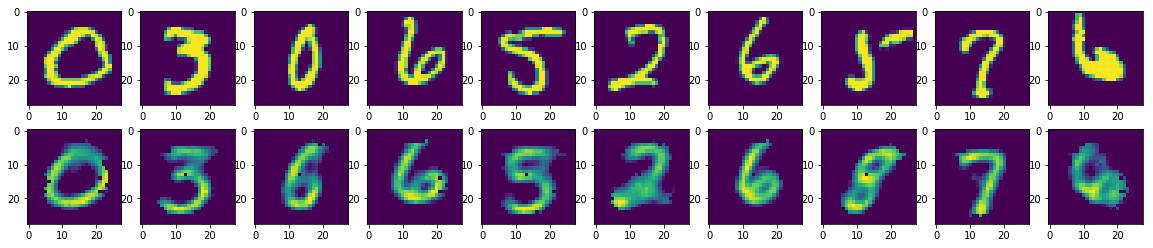

In [13]:
# Compare Test images to reconstructed, for 10 random images
idx = np.random.randint(low=0, high=len(testX), size=10)
f,a=plt.subplots(2,10,figsize=(20,4))

for count, row in enumerate(idx):
    a[0][count].imshow(np.reshape(testX[row],(28,28)))
    a[1][count].imshow(np.reshape(recreated[row],(28,28)))